# Value of ecosystem monitoring for fisheries managment 

In [1]:
include("../src/ValueFunctions.jl")
include("../src/BeliefStateTransitions.jl")
include("SurplusProduction.jl")
include("../src/MDPsolver.jl")
using Plots
using LaTeXStrings
using Colors
using Distributions

## Base model 

In [2]:
include("SurplusProduction.jl")
Fmsy= 0.2; price=1.0;sigma_a=0.1;sigma_p=1.5;NMVmax = 1.0;Sigma_N=0.05
MSY=10;pstar=0.4;c1 = 1.0/Fmsy;c2=0.0085
c3=1.0;b=2*Fmsy/MSY;discount=0.05;SigmaN=0.05
model=SurplusProduction.init_model(MSY,Fmsy,pstar,SigmaN,sigma_a,sigma_p,c1,c2,c3,b,
                                        NMVmax*MSY,discount;price=price,N=10,actions=[1,2],CVmax=1.05)
print(" ")

In [3]:
model.mod.fixed_control(([log(100)],[0.1;;]))

18.460196711321522

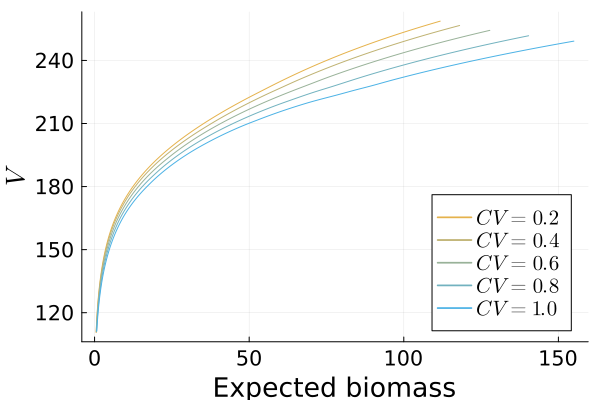

In [3]:
using Colors
sigma = [log(0.2^2+1), log(0.4^2+1),log(0.6^2+1),log(0.8^2+1), log(1.0^2+1)]


meanNodes = log(0.5):0.005:log(110)
p1 = Plots.plot(exp.(meanNodes.+0.5*sigma[1]),broadcast(x->model.Value([x,sigma[1]]), meanNodes), label = L"CV = 0.2",
            c = Colors.RGB(0.9,0.7,0.3))
Plots.plot!(exp.(meanNodes.+0.5*sigma[2]),broadcast(x->model.Value([x,sigma[2]]), meanNodes), label = L"CV = 0.4",
            c = Colors.RGB(0.75,0.7,0.45))
Plots.plot!(exp.(meanNodes.+0.5*sigma[3]),broadcast(x->model.Value([x,sigma[3]]), meanNodes), label = L"CV = 0.6",
            c = Colors.RGB(0.6,0.7,0.6))
Plots.plot!(exp.(meanNodes.+0.5*sigma[4]),broadcast(x->model.Value([x,sigma[4]]), meanNodes), label = L"CV = 0.8",
            c = Colors.RGB(0.45,0.7,0.75))
Plots.plot!(exp.(meanNodes.+0.5*sigma[5]),broadcast(x->model.Value([x,sigma[5]]), meanNodes), label = L"CV = 1.0",
            c = Colors.RGB(0.3,0.7,0.9),xlab = "Expected biomass", ylab = L"V", 
            legend = :bottomright,tickfontsize = 14,guidefontsize=18,legendfontsize=14)
savefig("figures/V_functions_base_40_10.png")
p1

In [94]:
CV_vals = collect(0.01:0.005:1.0)
Bhat_vals = 1:1.0:100
monitoring = zeros(length(Bhat_vals),length(CV_vals))
    
acc = zeros(length(CV_vals)*length(Bhat_vals),3)  
k = 0
for i in 1:length(Bhat_vals)
    for j in 1:length(CV_vals)
        Var = log(CV_vals[j]^2+1)
        mu = log(Bhat_vals[i]) - 0.5*Var 
        k+=1
        acc[k,:] = [Bhat_vals[i],CV_vals[j],model.Policy([mu, Var]) .- 1]
    end 
end 


In [664]:
using CSV
using Tables
CSV.write("data/base_model_policy.csv",Tables.table(acc);sep=',')

"data/base_model_policy.csv"

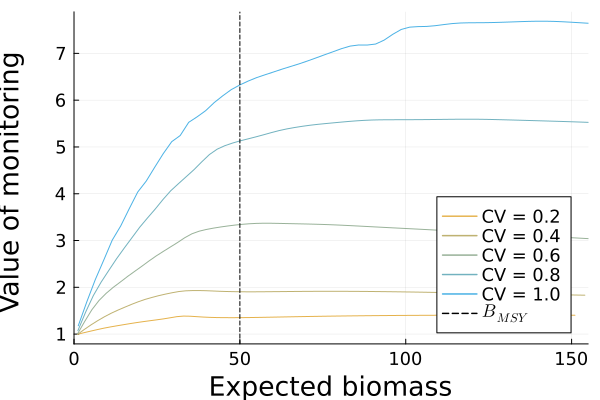

In [665]:
N = 100
values_1 = zeros(N,N)
values_0 = zeros(N,N)
V_ = zeros(N,N)
for i in 1:N
    for j in 1:N
        values_1[i,j]=MDPsolver.bellman!(zeros(2),2,i,j,model.grid,model.Value,model.rewards,0.9524).+ 2.0
        values_0[i,j]=MDPsolver.bellman!(zeros(2),1,i,j,model.grid,model.Value,model.rewards,0.9524)
        vals = [values_1[i,j],values_0[i,j]]
        V_[i,j] = vals[argmax(vals)]
    end 
end 

# Define value function 
Bmax = 150.0
Bmin = 0.1
CVmax = 0.75
VoI = ValueFunctions.init_Norm2DGrid(log(Bmax),log(Bmin),log(CVmax^2+1),N)
VoI.values = reshape(values_1.-values_0, N^2)
ValueFunctions.update1!(VoI)



sigma = [log(0.01^2+1), log(0.2^2+1),log(0.4^2+1),log(0.6^2+1), log(0.8^2+1)]

mu_sd1 = log.(collect(1.0:2.0:151))


p2 = Plots.plot(exp.(mu_sd1 .+ 0.5*sigma[1]),broadcast(i -> VoI([mu_sd1[i], sigma[1]]), 1:length(mu_sd1)),
label = "CV = 0.2",c = Colors.RGB(0.9,0.7,0.3))
Plots.plot!(exp.(mu_sd1.+ 0.5*sigma[2]),broadcast(i -> VoI([mu_sd1[i], sigma[2]]), 1:length(mu_sd1)),
label = "CV = 0.4",c = Colors.RGB(0.75,0.7,0.45))
Plots.plot!(exp.(mu_sd1.+ 0.5*sigma[3]),broadcast(i -> VoI([mu_sd1[i], sigma[3]]), 1:length(mu_sd1)),
label = "CV = 0.6",c = Colors.RGB(0.6,0.7,0.6))
Plots.plot!(exp.(mu_sd1.+ 0.5*sigma[4]),broadcast(i -> VoI([mu_sd1[i], sigma[4]]), 1:length(mu_sd1)),
label = "CV = 0.8",c = Colors.RGB(0.45,0.7,0.75))
Plots.plot!(exp.(mu_sd1.+ 0.5*sigma[5]),broadcast(i -> VoI([mu_sd1[i], sigma[5]]), 1:length(mu_sd1)),
label = "CV = 1.0", c = Colors.RGB(0.3,0.7,0.9), xlab = "Expected biomass",
ylab = string("Value of monitoring \n"),
xguidefontsize=18,yguidefontsize=18,xtickfontsize=12,ytickfontsize=12,legendfontsize=12,
legend = :bottomright,xlims = (0,155))
Plots.vline!([50], label = L"B_{MSY}", linestyle = :dash, color = "black")
savefig("figures/VoI_base_40_10.png")
p2

# Simulations 

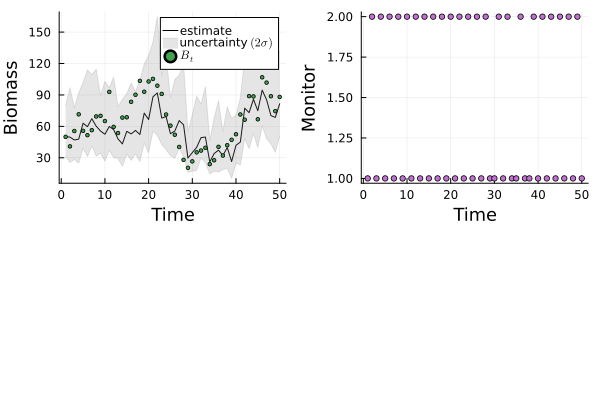

In [666]:
x0 = [log(MSY/Fmsy)];s0 = ([log(MSY/Fmsy)], [0.05;;]);T = 50;Nmc=1000
filter_ = BeliefStateTransitions.ParticleFilters.init(Nmc,Distributions.MvNormal(s0[1],s0[2]))
dat = BeliefStateTransitions.simulation(x0,s0,T,filter_,model.Policy,model.mod,model.Returns)

p1=Plots.plot(broadcast(i -> exp.(dat[2][i][1][1]), 1:T), color = "black", label = "estimate")
Plots.plot!(broadcast(i -> exp.(dat[2][i][1][1] + 2*sqrt(dat[2][i][2][1])), 1:T), 
            fillrange = broadcast(i -> exp.(dat[2][i][1][1] - 2*sqrt(dat[2][i][2][1])), 1:T), 
            alpha =0.2, color = "grey", label = string("uncertainty ", L"(2\sigma)") , ylab = "Biomass")
Plots.scatter!(broadcast(i -> exp(dat[1][i][1]), 1:T), markersize= 2, label = L"B_t")
Plots.plot!(broadcast(i -> exp.(dat[2][i][1][1]- 2*sqrt(dat[2][i][2][1])), 1:T), color = "grey",
            alpha = 0.2, label = "", xlab = "Time")
p2 = Plots.plot(broadcast(i -> dat[5][i][1][1], 1:T), color = "black", label = "", xlabel = "Time",
ylab = "Profit")
p3=Plots.scatter(broadcast(i -> dat[3][i], 1:T), color = "black", legend = :right, c=4, markersize= 3,
        ylab = "Monitor", xlab = "Time",label = "")
p4=Plots.plot(broadcast(i -> dat[4][i], 1:T), color = "black", label = "", xlabel = "Time",
ylab = "Harvest")
plot(p1,p3,layout = (2,2),guidefontsize = 12,tickfontsize = 8)

In [667]:
x0 = [log(MSY/Fmsy)];s0 = ([log(MSY/Fmsy)], [0.3;;]);T = 2000;Nmc=1000
filter_ = BeliefStateTransitions.ParticleFilters.init(Nmc,Distributions.MvNormal(s0[1],s0[2]))
dat = BeliefStateTransitions.simulation(x0,s0,T,filter_,model.Policy,model.mod,model.Returns)


Ht = broadcast(i -> dat[4][i], 1:(T-1))./exp.(broadcast(i -> dat[2][i][1][1], 1:(T-1)))
delta_CV = broadcast(i -> sqrt(exp(dat[2][i][2][1])-1)-sqrt(exp(dat[2][i-1][2][1])-1), 2:T)
CV0 = broadcast(i ->sqrt(exp(dat[2][i-1][2][1])-1), 2:T)
monitor = broadcast(i -> dat[3][i], 1:(T-1))
Plots.scatter(Ht[monitor.==1],delta_CV[monitor.==1])
Plots.scatter!(Ht[monitor.==2],delta_CV[monitor.==2])

dat1 = hcat(Ht,delta_CV,CV0,monitor)

using CSV
using Tables
CSV.write("data/Harvest_delta_CV.csv",Tables.table(dat1);sep=',')

"data/Harvest_delta_CV.csv"

In [85]:
log(0.75^2+1)

0.44628710262841953

In [86]:
log(0.5^2+1)

0.22314355131420976

In [89]:
log(0.25^2+1)

0.06062462181643484

# Higher monitoring costs 

In [106]:
include("SurplusProduction.jl")
Fmsy= 0.2; price=0.5;sigma_a=0.1;sigma_p=1.5;NMVmax = 1.0;Sigma_N=0.05
MSY=10.0;pstar=0.4;c1 = 1.0/Fmsy;c2=0.0085
c3=1.0
b=2*Fmsy/MSY;discount=0.05;SigmaN=0.05
model_c3_2=SurplusProduction.init_model(MSY,Fmsy,pstar,SigmaN,sigma_a,sigma_p,c1,c2,c3,b,
                                        NMVmax*MSY,discount;price=price,N=100,actions=[1,2],CVmax=1.05)
print(" ")

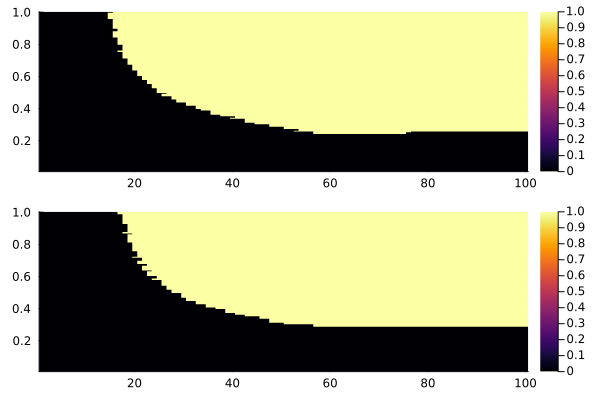

In [107]:
CV_vals = collect(0.01:0.005:1.0)
Bhat_vals = 1:1.0:100
monitoring = zeros(length(Bhat_vals),length(CV_vals))
    
acc_c3_2 = zeros(length(CV_vals)*length(Bhat_vals),3)  
k = 0
for i in 1:length(Bhat_vals)
    for j in 1:length(CV_vals)
        Var = log(CV_vals[j]^2+1)
        mu = log(Bhat_vals[i]) - 0.5*Var 
        k+=1
        acc_c3_2[k,:] = [Bhat_vals[i],CV_vals[j],model_c3_2.Policy([mu, Var]) .- 1]
    end 
end 
p1=Plots.heatmap(Bhat_vals,CV_vals,reshape(acc_c3_2[:,3],length(CV_vals),length(Bhat_vals)))
p2=Plots.heatmap(Bhat_vals,CV_vals,reshape(acc[:,3],length(CV_vals),length(Bhat_vals)))
plot(p1,p2,layout = (2,1))

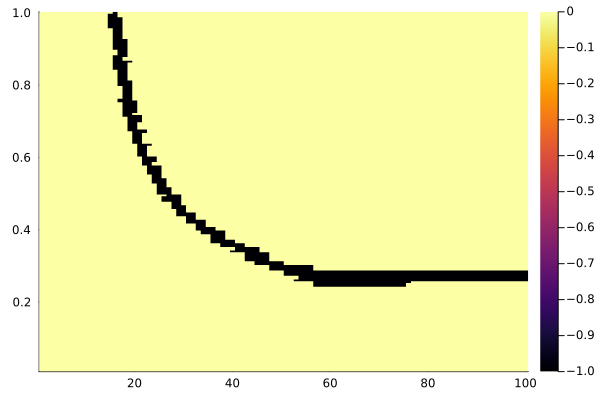

In [108]:
# differnce between base model and higher costs
Plots.heatmap(Bhat_vals,CV_vals,reshape(acc[:,3],length(CV_vals),length(Bhat_vals)) .- 
                reshape(acc_c3_2[:,3],length(CV_vals),length(Bhat_vals)))

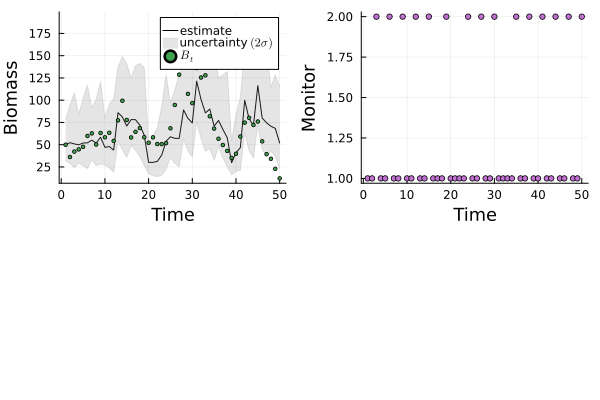

In [29]:
x0 = [log(MSY/Fmsy)];s0 = ([log(MSY/Fmsy)], [0.05;;]);T = 50;Nmc=1000
filter_ = BeliefStateTransitions.ParticleFilters.init(Nmc,Distributions.MvNormal(s0[1],s0[2]))
dat = BeliefStateTransitions.simulation(x0,s0,T,filter_,model_c3_2.Policy,model_c3_2.mod,model_c3_2.Returns)

p1=Plots.plot(broadcast(i -> exp.(dat[2][i][1][1]), 1:T), color = "black", label = "estimate")
Plots.plot!(broadcast(i -> exp.(dat[2][i][1][1] + 2*sqrt(dat[2][i][2][1])), 1:T), 
            fillrange = broadcast(i -> exp.(dat[2][i][1][1] - 2*sqrt(dat[2][i][2][1])), 1:T), 
            alpha =0.2, color = "grey", label = string("uncertainty ", L"(2\sigma)") , ylab = "Biomass")
Plots.scatter!(broadcast(i -> exp(dat[1][i][1]), 1:T), markersize= 2, label = L"B_t")
Plots.plot!(broadcast(i -> exp.(dat[2][i][1][1]- 2*sqrt(dat[2][i][2][1])), 1:T), color = "grey",
            alpha = 0.2, label = "", xlab = "Time")
p2 = Plots.plot(broadcast(i -> dat[5][i][1][1], 1:T), color = "black", label = "", xlabel = "Time",
ylab = "Profit")
p3=Plots.scatter(broadcast(i -> dat[3][i], 1:T), color = "black", legend = :right, c=4, markersize= 3,
        ylab = "Monitor", xlab = "Time",label = "")
p4=Plots.plot(broadcast(i -> dat[4][i], 1:T), color = "black", label = "", xlabel = "Time",
ylab = "Harvest")
plot(p1,p3,layout = (2,2),guidefontsize = 12,tickfontsize = 8)

# Solve for CV level

In [83]:
function argswitch(row,observations,values)
    row = observations[row,:]
    for i in 1:length(row)
        if row[i] == 2.0
            return values[i]
        end 
    end 
    return values[end]
end 
function minswitch(observations,values)
    acc = zeros(100)
    for i in 1:100
        acc[i] = argswitch(i,observations,values)
    end
    return acc[argmin(acc)]
end 
minswitch(model.Policy.observations,model.Policy.nodesVar)

0.0854596179794711

In [81]:
log(0.388^2+1)

0.14023487400362522

# Quantities of interest
- $\hat{B}$
- $\sigma$
- $\sigma_{\nu}$
- $\sigma_a$
- $F_{MSY}$
- price
- non-market value


$S_{T_i} = \frac{1}{N}\sum_{n=1}^N \left(F(A_n) - F(A_{B_n}^i)\right)^2$

$f_{X_{\sim 1,2}}(x_3,x_4,x_5,...)=E_{X_{1,2}}[Y|X_{\sim 1,2}]$

$f_{X_3}(x_3) = E_{\sim X_3}[Y|X_{3}]$

In [328]:
include("SurplusProduction.jl")

function EVoI!(acc,ind0,sigma_a,sigma_p,SigmaN,Fmsy,NMVmax,price)
    # 300
    MSY=10;pstar=0.4;c1 = 1.0/Fmsy;c2=0.0085
    c3=1.0;b=2*Fmsy/MSY;discount=0.05
    model=SurplusProduction.init_model(MSY,Fmsy,pstar,SigmaN,sigma_a,sigma_p,c1,c2,c3,b,
                                        NMVmax,discount;price=price,N=25,actions=[1,2])
    
    Bhat = (1:(0.1*4*MSY/Fmsy):(4*MSY/Fmsy))
    sigma = 0.01:0.07:0.7

    
    n=0
    for i in 1:length(Bhat)
        for j in 1:length(sigma)
            n+=1
            acc[ind0+n,:] = [sigma_a,sigma_p,SigmaN,Fmsy,NMVmax,price,Bhat[i],sigma[j],model.VoI([log(Bhat[i]),sigma[j]])]
        end
    end 
    
    for i in 1:200
        Bhat= 4*MSY*rand()/Fmsy
        sigma =rand()*0.7
        acc[ind0+n+i,:] = [sigma_a,sigma_p,SigmaN,Fmsy,NMVmax,price,Bhat,sigma,model.VoI([log(Bhat),sigma])]
    end 
    
    return acc
end 


function sample()
    sigma_a=0.05+(0.5-0.05)*rand()
    sigma_p=0.75+(3.0-0.75)*rand()
    SigmaN=0.01+(0.1-0.01)*rand()
    Fmsy=0.075+(0.5-0.075)*rand()
    NMVmax=4*10*rand()
    price=0.333+(3.0-0.333)*rand()
    return (sigma_a,sigma_p,SigmaN,Fmsy,NMVmax,price)
end 



sample (generic function with 1 method)

In [ ]:
Nmc = 500
acc = zeros(300*Nmc,9)
for i in 1:Nmc
    print(i," ")
    sigma_a,sigma_p,SigmaN,Fmsy,NMVmax,price=sample()
    EVoI!(acc,(i-1)*300,sigma_a,sigma_p,SigmaN,Fmsy,NMVmax,price)
end 
using CSV
using Tables
CSV.write("data/VoI.csv",Tables.table(acc);sep=',')

# Optimal policy 

In [628]:
length(0.01:0.1:1.0)

10

In [629]:
include("SurplusProduction.jl")
function Policy!(acc,ind0,sigma_a,sigma_p,SigmaN,Fmsy,NMVmax,price)
    # 300
    MSY=10;pstar=0.4;c1 = 1.0/Fmsy;c2=0.0085
    c3=1.0;b=2*Fmsy/MSY;discount=0.05
    model=SurplusProduction.init_model(MSY,Fmsy,pstar,SigmaN,sigma_a,sigma_p,c1,c2,c3,b,
                                        NMVmax,discount;price=price,N=25,actions=[1,2])
    
    Bhat = (1:(0.1*2*MSY/Fmsy):(2*MSY/Fmsy))
    CV = 0.01:0.1:1.0

    
    n=0
    for i in 1:length(Bhat)
        for j in 1:length(CV)
            n+=1
            Var = log(CV[j]^2+1)
            mu = log(Bhat[i]) - 0.5*Var 
            acc[ind0+n,:] = [sigma_a,sigma_p,SigmaN,Fmsy,NMVmax,price,Bhat[i],CV[j],model.Policy([mu,Var])]
        end
    end 
    
    for i in 1:400
        Bhat= 2*MSY*rand()/Fmsy
        CV =rand()*1.0
        Var = log(CV^2+1)
        mu = log(Bhat) - 0.5*Var 
        acc[ind0+n+i,:] = [sigma_a,sigma_p,SigmaN,Fmsy,NMVmax,price,Bhat,CV,model.Policy([mu,Var])]
    end 
    
    return acc
end 


Policy! (generic function with 1 method)

In [630]:
Nmc = 100
acc = zeros(500*Nmc,9)
for i in 1:Nmc
    print(i," ")
    sigma_a,sigma_p,SigmaN,Fmsy,NMVmax,price=sample()
    Policy!(acc,(i-1)*500,sigma_a,sigma_p,SigmaN,Fmsy,NMVmax,price)
end 
using CSV
using Tables
CSV.write("data/Policies.csv",Tables.table(acc);sep=',')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

"data/Policies.csv"

# Frequency of monitoring

In the previous section I looked at the value of monitoring in a single period as a function of the model parameters and the beleif state. This quantity is useful for thinking about what factors might influence the reletivevalue of aassining stocks in a given year assuming limited resources. However, it does not capture the effect of the parameters on the frequency of assessents. Some model paramters effect how quickly uncertinaty about the state of the popualtion increases. The faster unceritanty increases the more frequently a stock sould be assessed all else equal. 

To develop some intuition about this I do three things. First, I used simualtions of the beleif state dynamics over a range of paramter vlaues to identify the effect of each parameter on the rate the belef state varaince increases over time. Next, I calcualted the increase in the value of monitoring over time after as a function of the model paramters and inital beleif state. These first two analyses provided some useful intuition, but do not explicitly identify optimal assessment frequency. 

In the third analysis I use simulations to calcualte the fraction of years in which an assessment occurs. 

In [ ]:
MSY=10;Fmsy=0.2;pstar=0.4;SigmaN=0.01;sigma_a=0.1;sigma_p=1.5
c1=2.0/Fmsy;c2=0.0085;c3=1.0;discount=0.05;NMVmax=10;b=2*Fmsy/MSY
model=SurplusProduction.init_model(MSY,Fmsy,pstar,SigmaN,sigma_a,sigma_p,c1,c2,c3,b,NMVmax,discount;N=2,actions=[1,2])


In [ ]:
function sigma_t!(acc,ind0,SigmaN,Fmsy)
    # 300
    MSY=10;pstar=0.4;sigma_p=1.5;c1 = 1.0/Fmsy;c2=0.0085
    c3=1.0;b=2*Fmsy/MSY;discount=0.05
    model=SurplusProduction.init_model(MSY,Fmsy,pstar,SigmaN,0.1,sigma_p,c1,c2,c3,b,
                                        1.0,discount;N=3,actions=[1,2])
    
    s = ([log(MSY/Fmsy)],[0.01;;])
    quad = BeliefStateTransitions.MvGaussHermite.init_mutable(10,s[1],s[2])
    Bhat = (1:(0.1*4*MSY/Fmsy):(4*MSY/Fmsy))
    sigma = 0.01:0.07:0.7

    
    n=0
    for i in 1:length(Bhat)
        for j in 1:length(sigma)
            s = ([log(Bhat[i])],[sigma[i];;])
            for t in 1:4
                n+=1
                s = BeliefStateTransitions.time_update!(s,model.mod,quad)
                acc[ind0+n,:] = [SigmaN,Fmsy,Bhat[i],sigma[j],t,s[2][1,1]]
            end
        end
    end 
    
    m = 0
    for i in 1:200
        Bhat= 4*MSY*rand()/Fmsy
        sigma =rand()*0.7
        s = ([log(Bhat)],[sigma;;])
        for t in 1:4
                m+=1
                s = BeliefStateTransitions.time_update!(s,model.mod,quad)
                acc[ind0+n+m,:] = [SigmaN,Fmsy,Bhat,sigma,t,s[2][1,1]]          
        end
    end 
       
end
acc = zeros(4*300,)
sigma_t!(acc,0,SigmaN,Fmsy)

In [ ]:
Nmc = 1000
acc = zeros(Nmc*4*500,6)
for i in 1:Nmc
    print(i," ")
    sigma_a,SigmaN,Fmsy,NMVmax,price=sample()
    sigma_t!(acc,(i-1)*4*300,SigmaN,Fmsy)
end 
using CSV
using Tables
CSV.write("data/sigma_t.csv",Tables.table(acc);sep=',')

In [ ]:
include("../src/BeliefStateTransitions.jl")
s = ([log(MSY/Fmsy)],[0.01;;])
quad = BeliefStateTransitions.MvGaussHermite.init_mutable(10,s[1],s[2])
println(s)
s1=BeliefStateTransitions.time_update!(s,model.mod,quad)
println(s1)
s2=BeliefStateTransitions.time_update!(s1,model.mod,quad)
println(s2)
s3=BeliefStateTransitions.time_update!(s2,model.mod,quad)
println(s3)
s4=BeliefStateTransitions.time_update!(s3,model.mod,quad)
println(s4)

In [ ]:
function EVoI_t!(acc,ind0,sigma_a,SigmaN,Fmsy,NMVmax,price)
    # 300
    MSY=10;pstar=0.4;sigma_p=1.5;c1 = 1.0/Fmsy;c2=0.0085
    c3=1.0;b=2*Fmsy/MSY;discount=0.05
    model=SurplusProduction.init_model(MSY,Fmsy,pstar,SigmaN,sigma_a,sigma_p,c1,c2,c3,b,
                                        NMVmax,discount;price=price,N=25,actions=[1,2])
    
    s = ([log(MSY/Fmsy)],[0.01;;])

    for t in 1:4
        acc[ind0+t,:] = [sigma_a,SigmaN,Fmsy,NMVmax,price,t,model.VoI([s[1][1],s[2][1,1]])]
        s = BeliefStateTransitions.time_update!(s,model.mod,quad)
    end 
    acc[ind0+5,:] = [sigma_a,SigmaN,Fmsy,NMVmax,price,T+1,model.VoI([s[1][1],s[2][1,1]])]
    
end 

sigma_a,SigmaN,Fmsy,NMVmax,price=sample()
EVoI_t!(acc,(1-1)*(T+1),sigma_a,SigmaN,Fmsy,NMVmax,price)

In [ ]:
Nmc = 5000
acc = zeros(5*Nmc,7)

for i in 1:Nmc
    print(i," ")
    sigma_a,SigmaN,Fmsy,NMVmax,price=sample()
    EVoI_t!(acc,(i-1)*5,sigma_a,SigmaN,Fmsy,NMVmax,price)
end 
using CSV
using Tables
CSV.write("data/VoI_T.csv",Tables.table(acc);sep=',')

# Assessment frequency

Here the goal is to measure how the model parameters effect the target assessment frequency. The assessment frequency depends on two factors, the value of monitoring given the state of the fishery and the dynamics of the beleif state. Here I use simualtion from the optimal policy function and calcualte the fraction of years in which an assessment occurs. I calcualted this value of a range of input parameters to identify their effects. 

Some factors that are likely important are 
- Variability ($\sigma_{\nu}$)
- Productivity ($F_{msy}$)
- Harvest value (price)
- non-market value (NMVmax)
- accuracy $\sigma_a$
- passive infor $\sigma_p$

In [343]:
using Distributions
include("SurplusProduction.jl")
include("../src/BeliefStateTransitions.jl")
function assessment_frequency!(sigma_a,sigma_p,SigmaN,Fmsy,NMVmax,price)
    # 300
    MSY=10;pstar=0.4;c1 = 1.0/Fmsy;c2=0.0085
    c3=1.0;b=2*Fmsy/MSY;discount=0.05
    model=SurplusProduction.init_model(MSY,Fmsy,pstar,SigmaN,sigma_a,sigma_p,c1,c2,c3,b,
                                        NMVmax,discount;price=price,N=25,actions=[1,2])
    
    models = broadcast(i->deepcopy(model),1:10)
    monitor = zeros(10)
    Threads.@threads for i in 1:10
        x0 = [log(MSY/Fmsy)];s0 = ([log(MSY/Fmsy)], [0.3;;]);T = 500;Nmc=250
        #filter = BeliefStateTransitions.ParticleFilters.init(Nmc,Distributions.MvNormal(s0[1],s0[2]))
        quad = BeliefStateTransitions.MvGaussHermite.init_mutable(10,s0[1],s0[2])
        #dat = BeliefStateTransitions.simulation(x0,s0,T,filter,models[i].Policy,models[i].mod,models[i].Returns)
        dat=BeliefStateTransitions.simulation_kf(x0,s0,T,filter,models[i].Policy,models[i].mod,models[i].Returns,quad)
    
        inds = collect(1:T)[broadcast(i -> exp.(dat[2][i][1][1]), 1:T) .> 0.75*MSY/Fmsy]
        monitor[i] = 0.1*sum(broadcast(i -> dat[3][i], inds) .- 1)/length(inds)
        
    end 
    
    return sum(monitor)
end


function sample()
    sigma_a=0.05+(0.5-0.05)*rand()
    sigma_p=0.75+(3.0-0.75)*rand()
    SigmaN=0.01+(0.1-0.01)*rand()
    Fmsy=0.075+(0.5-0.075)*rand()
    NMVmax=4*10*rand()
    price=0.333+(3.0-0.333)*rand()
    return (sigma_a,sigma_p,SigmaN,Fmsy,NMVmax,price)
end 

sample (generic function with 1 method)

In [ ]:
Nmc = 10000
acc = zeros(Nmc,7)

for n in 1:Nmc
    print(n," ")
    sigma_a,sigma_p,SigmaN,Fmsy,NMVmax,price=sample()
    acc[n,:] = [sigma_a,sigma_p,SigmaN,Fmsy,NMVmax,price,assessment_frequency!(sigma_a,sigma_p,SigmaN,Fmsy,NMVmax,price)]
end 
using CSV
using Tables
CSV.write("data/frequency.csv",Tables.table(acc);sep=',')

In [344]:
assessment_frequency!(0.1,1.5,0.05,0.15,30,1.0)

0.5159910108216561

In [345]:
assessment_frequency!(0.1,1.5,0.05,0.15,30,1.0)

0.5117386984784015

In [346]:
assessment_frequency!(0.1,1.5,0.05,0.15,30,1.0)

0.5115362231765808

In [347]:
@time assessment_frequency!(0.1,1.5,0.05,0.15,30,1.0)

  1.341436 seconds (56.50 M allocations: 1.650 GiB, 17.62% gc time)


0.514227887444225

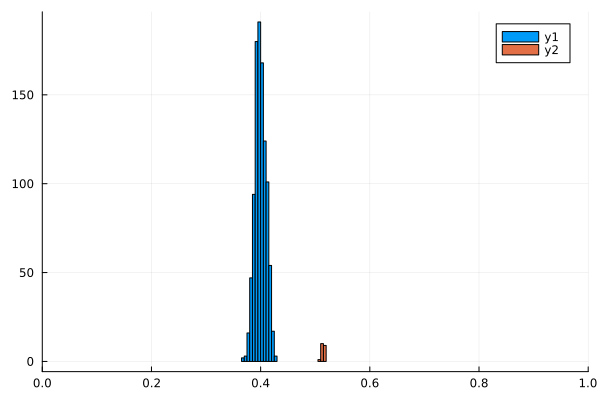

In [348]:
Plots.histogram(broadcast(i->sum(rand(2500).<0.4)/2500,1:1000),xlim=(0,1))
Plots.histogram!(broadcast(i->assessment_frequency!(0.1,1.5,0.05,0.15,30,1.0),1:20),xlim=(0,1))
    

# useful ploting functions

In [232]:
function ranges(x)
    indicator = 0
    on = []
    off = []
    for i in 1:length(x)
        if (indicator==0) && (x[i]==1)
            indicator =1
            push!(on, i)
        elseif (indicator==1) && (x[i]==0)
            indicator=0
            push!(off,i)
        end 
    end
    if length(off) < length(on)
        push!(off,length(x))
    end 
    return on, off     
end 


function plot_ranges(p,x,col,alpha)
    on,off=ranges(x)
    for i in 1:length(on)
        p = Plots.vspan!(p,[on[i],off[i]], color = col, alpha = alpha,label = "")
    end 
    return p
end 

plot_ranges (generic function with 1 method)

In [265]:

function frequency(sequ)
    gaps = []
    count = 0
    for i in 1:length(sequ)
        if sequ[i] == 1
            push!(gaps,deepcopy(count))
            count = 0
        else
            count+=1
        end  
    end 
    return gaps
end


frequency (generic function with 1 method)

# Example simulations 

## $\sigma_{\nu} = 0.025$

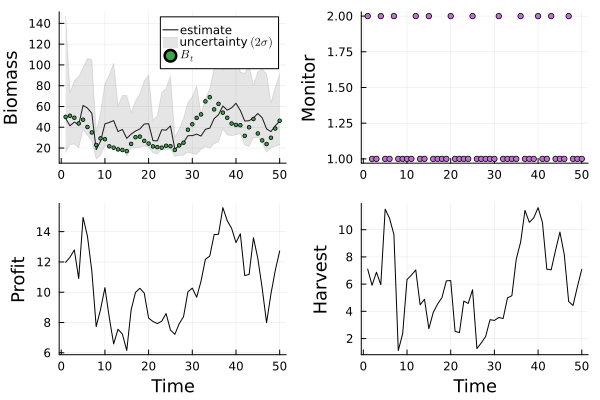

In [266]:
using FreqTables
include("SurplusProduction.jl")
include("../src/BeliefStateTransitions.jl")
using Distributions
using Plots
using LaTeXStrings
MSY=10;Fmsy=0.2;pstar=0.4;SigmaN=0.025;sigma_a=0.1;sigma_p=1.5
c1=10.0;c2=0.0085;c3=1.0;b=Fmsy;NMVmax=1.0*MSY;discount=0.05
model=SurplusProduction.init_model(MSY,Fmsy,pstar,SigmaN,sigma_a,sigma_p,c1,c2,c3,b,NMVmax,discount;N=25)
# print(" ")

x0 = [log(MSY/Fmsy)];s0 = ([log(MSY/Fmsy)], [0.3;;]);T = 50;Nmc=1000
filter_ = BeliefStateTransitions.ParticleFilters.init(Nmc,Distributions.MvNormal(s0[1],s0[2]))
dat = BeliefStateTransitions.simulation(x0,s0,T,filter_,model.Policy,model.mod,model.Returns)

p1=Plots.plot(broadcast(i -> exp.(dat[2][i][1][1]), 1:T), color = "black", label = "estimate")
Plots.plot!(broadcast(i -> exp.(dat[2][i][1][1] + 2*sqrt(dat[2][i][2][1])), 1:T), 
            fillrange = broadcast(i -> exp.(dat[2][i][1][1] - 2*sqrt(dat[2][i][2][1])), 1:T), 
            alpha =0.2, color = "grey", label = string("uncertainty ", L"(2\sigma)") , ylab = "Biomass")
Plots.scatter!(broadcast(i -> exp(dat[1][i][1]), 1:T), markersize= 2, label = L"B_t")
Plots.plot!(broadcast(i -> exp.(dat[2][i][1][1]- 2*sqrt(dat[2][i][2][1])), 1:T), color = "grey",
            alpha = 0.2, label = "")
p2 = Plots.plot(broadcast(i -> dat[5][i][1][1], 1:T), color = "black", label = "", xlabel = "Time",
ylab = "Profit")
monitor = broadcast(i -> dat[3][i], 1:T)
p3=Plots.scatter(broadcast(i -> dat[3][i], 1:T), color = "black", legend = :right, c=4, markersize= 3,ylab = "Monitor", label = "")
p4=Plots.plot(broadcast(i -> dat[4][i], 1:T), color = "black", label = "", xlabel = "Time",
ylab = "Harvest")
p=plot(p1,p3,p2,p4,layout = (2,2),guidefontsize = 12,tickfontsize = 8)
savefig("figures/sigma_N_001_simulation.png")
p

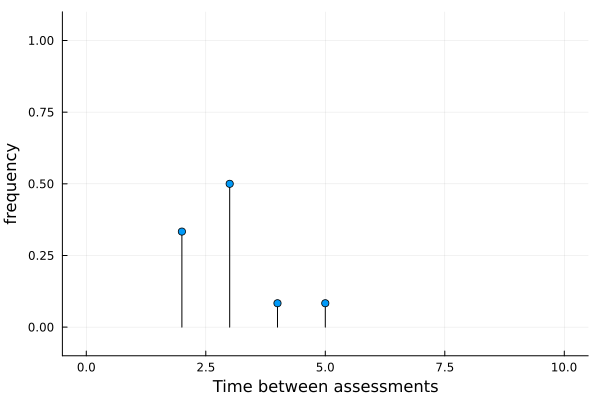

In [268]:
dat = BeliefStateTransitions.simulation(x0,s0,3000,filter_,model.Policy,model.mod,model.Returns)

monitor = broadcast(i -> dat[3][i], 1:T)
tbl = FreqTables.proptable(frequency(monitor .- 1))
x2 = repeat(names(tbl)[1], inner=3)    
y2 = reduce(vcat, [y, yhat, NaN] for (y, yhat) in zip(zeros(length(tbl)), tbl))
Plots.plot(x2, y2,color="black")
Plots.scatter!(names(tbl),tbl, ylims = (-0.1,1.1),c=1,
                xlab = "Time between assessments",
                ylab = "frequency", legend = false, xlims = (-0.5,10.5))


## $\sigma_{\nu} = 0.05$

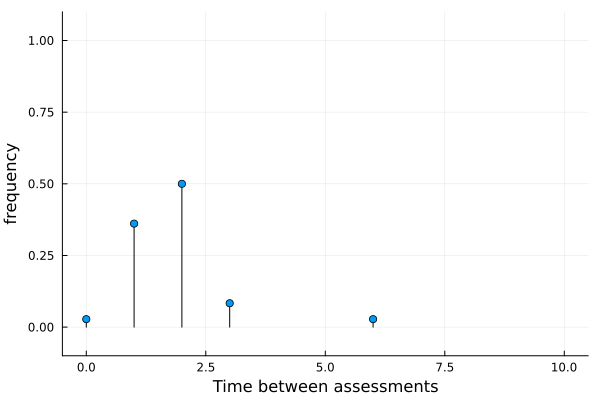

In [269]:
include("SurplusProduction.jl")
MSY=10;Fmsy=0.2;pstar=0.4;SigmaN=0.05;sigma_a=0.1;sigma_p=1.5
c1=10.0;c2=0.0085;c3=1.0;b=Fmsy;NMVmax=1.0*MSY;discount=0.05
model=SurplusProduction.init_model(MSY,Fmsy,pstar,SigmaN,sigma_a,sigma_p,c1,c2,c3,b,NMVmax,discount;N=25)
print(" ")

x0 = [log(MSY/Fmsy)];s0 = ([log(MSY/Fmsy)], [0.3;;]);T = 100;Nmc=1000
filter_ = BeliefStateTransitions.ParticleFilters.init(Nmc,Distributions.MvNormal(s0[1],s0[2]))
dat = BeliefStateTransitions.simulation(x0,s0,T,filter_,model.Policy,model.mod,model.Returns)

p1=Plots.plot(broadcast(i -> exp.(dat[2][i][1][1]), 1:T), color = "black", label = "estimate")
Plots.plot!(broadcast(i -> exp.(dat[2][i][1][1] + 2*sqrt(dat[2][i][2][1])), 1:T), 
            fillrange = broadcast(i -> exp.(dat[2][i][1][1] - 2*sqrt(dat[2][i][2][1])), 1:T), 
            alpha =0.2, color = "grey", label = string("uncertainty ", L"(2\sigma)") , ylab = "Biomass")
Plots.scatter!(broadcast(i -> exp(dat[1][i][1]), 1:T), markersize= 2, label = L"B_t")
Plots.plot!(broadcast(i -> exp.(dat[2][i][1][1]- 2*sqrt(dat[2][i][2][1])), 1:T), color = "grey",
            alpha = 0.2, label = "")
p2 = Plots.plot(broadcast(i -> dat[5][i][1][1], 1:T), color = "black", label = "", xlabel = "Time",
ylab = "Profit")
monitor = broadcast(i -> dat[3][i], 1:T)
p3=Plots.scatter(broadcast(i -> dat[3][i], 1:T), color = "black", legend = :right, c=4, markersize= 3,ylab = "Monitor", label = "")
p4=Plots.plot(broadcast(i -> dat[4][i], 1:T), color = "black", label = "", xlabel = "Time",
ylab = "Harvest")
p=plot(p1,p3,p2,p4,layout = (2,2),guidefontsize = 12,tickfontsize = 8)
savefig("figures/base_parameters_simulation")


dat = BeliefStateTransitions.simulation(x0,s0,3000,filter_,model.Policy,model.mod,model.Returns)

monitor = broadcast(i -> dat[3][i], 1:T)
tbl = FreqTables.proptable(frequency(monitor .- 1))
x2 = repeat(names(tbl)[1], inner=3)    
y2 = reduce(vcat, [y, yhat, NaN] for (y, yhat) in zip(zeros(length(tbl)), tbl))
Plots.plot(x2, y2,color="black")
Plots.scatter!(names(tbl),tbl, ylims = (-0.1,1.1),c=1,
                xlab = "Time between assessments",
                ylab = "frequency", legend = false, xlims = (-0.5,10.5))

# $\sigma_{\nu} = 0.1$

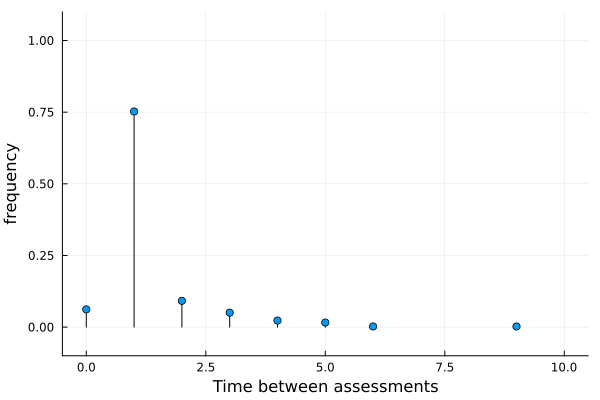

In [271]:
include("SurplusProduction.jl")
MSY=10;Fmsy=0.2;pstar=0.4;SigmaN=0.1;sigma_a=0.1;sigma_p=1.5
c1=10.0;c2=0.0085;c3=1.0;b=Fmsy;NMVmax=0.0*MSY;discount=0.05
model=SurplusProduction.init_model(MSY,Fmsy,pstar,SigmaN,sigma_a,sigma_p,c1,c2,c3,b,NMVmax,discount;N=25)
print(" ")

x0 = [log(MSY/Fmsy)];s0 = ([log(MSY/Fmsy)], [0.3;;]);T = 1000;Nmc=1000
filter_ = BeliefStateTransitions.ParticleFilters.init(Nmc,Distributions.MvNormal(s0[1],s0[2]))
dat = BeliefStateTransitions.simulation(x0,s0,T,filter_,model.Policy,model.mod,model.Returns)

p1=Plots.plot(broadcast(i -> exp.(dat[2][i][1][1]), 1:T), color = "black", label = "estimate")
Plots.plot!(broadcast(i -> exp.(dat[2][i][1][1] + 2*sqrt(dat[2][i][2][1])), 1:T), 
            fillrange = broadcast(i -> exp.(dat[2][i][1][1] - 2*sqrt(dat[2][i][2][1])), 1:T), 
            alpha =0.2, color = "grey", label = string("uncertainty ", L"(2\sigma)") , ylab = "Biomass")
Plots.scatter!(broadcast(i -> exp(dat[1][i][1]), 1:T), markersize= 2, label = L"B_t")
Plots.plot!(broadcast(i -> exp.(dat[2][i][1][1]- 2*sqrt(dat[2][i][2][1])), 1:T), color = "grey",
            alpha = 0.2, label = "")
p2 = Plots.plot(broadcast(i -> dat[5][i][1][1], 1:T), color = "black", label = "", xlabel = "Time",
ylab = "Profit")
monitor = broadcast(i -> dat[3][i], 1:T)
p3=Plots.scatter(broadcast(i -> dat[3][i], 1:T).-1, color = "black", legend = :right, c=4, markersize= 3,ylab = "Monitor", label = "")
p4=Plots.plot(broadcast(i -> dat[4][i], 1:T), color = "black", label = "", xlabel = "Time",
ylab = "Harvest")
p=plot(p1,p3,p2,p4,layout = (2,2),guidefontsize = 12,tickfontsize = 8,size=(800,500),left_margin = 5Plots.mm)
savefig("figures/sigma_N_005_simulation.png")


dat = BeliefStateTransitions.simulation(x0,s0,3000,filter_,model.Policy,model.mod,model.Returns)

monitor = broadcast(i -> dat[3][i], 1:T)
tbl = FreqTables.proptable(frequency(monitor .- 1))
x2 = repeat(names(tbl)[1], inner=3)    
y2 = reduce(vcat, [y, yhat, NaN] for (y, yhat) in zip(zeros(length(tbl)), tbl))
Plots.plot(x2, y2,color="black")
Plots.scatter!(names(tbl),tbl, ylims = (-0.1,1.1),c=1,
                xlab = "Time between assessments",
                ylab = "frequency", legend = false, xlims = (-0.5,10.5))

## $F_{MSY} = 0.1$

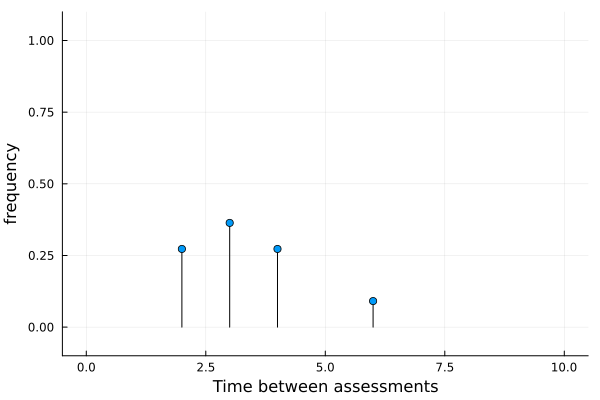

In [262]:
include("SurplusProduction.jl")
MSY=10;Fmsy=0.1;pstar=0.4;SigmaN=0.05;sigma_a=0.1;sigma_p=1.5
c1=10.0;c2=0.0085;c3=1.0;b=Fmsy;NMVmax=0.0*MSY;discount=0.05
model=SurplusProduction.init_model(MSY,Fmsy,pstar,SigmaN,sigma_a,sigma_p,c1,c2,c3,b,NMVmax,discount;N=25)
print(" ")

x0 = [log(MSY/Fmsy)];s0 = ([log(MSY/Fmsy)], [0.3;;]);T = 50;Nmc=1000
filter_ = BeliefStateTransitions.ParticleFilters.init(Nmc,Distributions.MvNormal(s0[1],s0[2]))
dat = BeliefStateTransitions.simulation(x0,s0,T,filter_,model.Policy,model.mod,model.Returns)

p1=Plots.plot(broadcast(i -> exp.(dat[2][i][1][1]), 1:T), color = "black", label = "estimate")
Plots.plot!(broadcast(i -> exp.(dat[2][i][1][1] + 2*sqrt(dat[2][i][2][1])), 1:T), 
            fillrange = broadcast(i -> exp.(dat[2][i][1][1] - 2*sqrt(dat[2][i][2][1])), 1:T), 
            alpha =0.2, color = "grey", label = string("uncertainty ", L"(2\sigma)") , ylab = "Biomass")
Plots.scatter!(broadcast(i -> exp(dat[1][i][1]), 1:T), markersize= 2, label = L"B_t")
Plots.plot!(broadcast(i -> exp.(dat[2][i][1][1]- 2*sqrt(dat[2][i][2][1])), 1:T), color = "grey",
            alpha = 0.2, label = "")
p2 = Plots.plot(broadcast(i -> dat[5][i][1][1], 1:T), color = "black", label = "", xlabel = "Time",
ylab = "Profit")
p3=Plots.scatter(broadcast(i -> dat[3][i], 1:T), color = "black", legend = :right, c=4, markersize= 3,ylab = "Monitor", label = "")
p4=Plots.plot(broadcast(i -> dat[4][i], 1:T), color = "black", label = "", xlabel = "Time",
ylab = "Harvest")

# plot regions of low abundance
x = broadcast(i->exp.(dat[2][i][1][1]), 1:T) .< 0.75*MSY/Fmsy
plot_ranges(p1,x,"grey",0.25)   
plot_ranges(p2,x,"grey",0.25)   
plot_ranges(p3,x,"grey",0.25)   
plot_ranges(p4,x,"grey",0.25) 


plot(p1,p3,p2,p4,layout = (2,2),guidefontsize = 12,tickfontsize = 8)
savefig("figures/FMSY_01_simulation.png")

dat = BeliefStateTransitions.simulation(x0,s0,2000,filter_,model.Policy,model.mod,model.Returns)

monitor = broadcast(i -> dat[3][i], 1:T)
tbl = FreqTables.proptable(frequency(monitor .- 1))
x2 = repeat(names(tbl)[1], inner=3)    
y2 = reduce(vcat, [y, yhat, NaN] for (y, yhat) in zip(zeros(length(tbl)), tbl))
Plots.plot(x2, y2,color="black")
Plots.scatter!(names(tbl),tbl, ylims = (-0.1,1.1),c=1,
                xlab = "Time between assessments",
                ylab = "frequency", legend = false, xlims = (-0.5,10.5))


## $F_{MSY} = 0.3$

In [263]:
include("SurplusProduction.jl")
MSY=10;Fmsy=0.3;pstar=0.4;SigmaN=0.05;sigma_a=0.1;sigma_p=1.5
c1=10.0;c2=0.0085;c3=1.0;b=Fmsy;NMVmax=0.0*MSY;discount=0.05
model=SurplusProduction.init_model(MSY,Fmsy,pstar,SigmaN,sigma_a,sigma_p,c1,c2,c3,b,NMVmax,discount;N=25)
print(" ")

x0 = [log(MSY/Fmsy)];s0 = ([log(MSY/Fmsy)], [0.3;;]);T = 50;Nmc=1000
filter_ = BeliefStateTransitions.ParticleFilters.init(Nmc,Distributions.MvNormal(s0[1],s0[2]))
dat = BeliefStateTransitions.simulation(x0,s0,T,filter_,model.Policy,model.mod,model.Returns)

p1=Plots.plot(broadcast(i -> exp.(dat[2][i][1][1]), 1:T), color = "black", label = "estimate")
Plots.plot!(broadcast(i -> exp.(dat[2][i][1][1] + 2*sqrt(dat[2][i][2][1])), 1:T), 
            fillrange = broadcast(i -> exp.(dat[2][i][1][1] - 2*sqrt(dat[2][i][2][1])), 1:T), 
            alpha =0.2, color = "grey", label = string("uncertainty ", L"(2\sigma)") , ylab = "Biomass")
Plots.scatter!(broadcast(i -> exp(dat[1][i][1]), 1:T), markersize= 2, label = L"B_t")
Plots.plot!(broadcast(i -> exp.(dat[2][i][1][1]- 2*sqrt(dat[2][i][2][1])), 1:T), color = "grey",
            alpha = 0.2, label = "")
p2 = Plots.plot(broadcast(i -> dat[5][i][1][1], 1:T), color = "black", label = "", xlabel = "Time",
ylab = "Profit")
p3=Plots.scatter(broadcast(i -> dat[3][i], 1:T), color = "black", legend = :right, c=4, markersize= 3,ylab = "Monitor", label = "")
p4=Plots.plot(broadcast(i -> dat[4][i], 1:T), color = "black", label = "", xlabel = "Time",
ylab = "Harvest")

# plot regions of low abundance
x = broadcast(i->exp.(dat[2][i][1][1]), 1:T) .< 0.75*MSY/Fmsy
plot_ranges(p1,x,"grey",0.25)   
plot_ranges(p2,x,"grey",0.25)   
plot_ranges(p3,x,"grey",0.25)   
plot_ranges(p4,x,"grey",0.25)  


plot(p1,p3,p2,p4,layout = (2,2),guidefontsize = 12,tickfontsize = 8)
savefig("figures/FMSY_03_simulation.png")

"/Users/johnbuckner/github/KalmanFilterPOMDPs/examples/figures/FMSY_03_simulation.png"

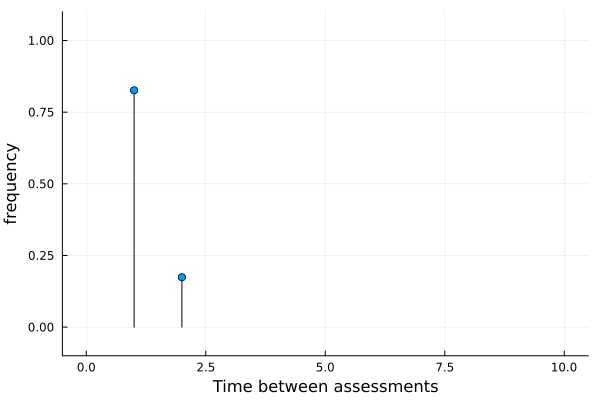

In [264]:
dat = BeliefStateTransitions.simulation(x0,s0,1000,filter_,model.Policy,model.mod,model.Returns)

monitor = broadcast(i -> dat[3][i], 1:T)
tbl = FreqTables.proptable(frequency(monitor .- 1))
x2 = repeat(names(tbl)[1], inner=3)    
y2 = reduce(vcat, [y, yhat, NaN] for (y, yhat) in zip(zeros(length(tbl)), tbl))
Plots.plot(x2, y2,color="black")
Plots.scatter!(names(tbl),tbl, ylims = (-0.1,1.1),c=1,
                xlab = "Time between assessments",
                ylab = "frequency", legend = false, xlims = (-0.5,10.5))


In [582]:
include("SurplusProduction.jl")
MSY = 10
Fmsy = 0.2
F_target = Fmsy
B_threshold = MSY/Fmsy
max_effort = 30.9
inflection_point = 0.1*B_threshold
pstar = 0.5
SigmaN = 0.025
sigma_a = 0.1 
sigma_p = 2.0
c1 = 0.0
c2 = 0.0
c3 = 1.0
b = 0.0
maxV = 0.0
discount = 1/1.05 #F_target,B_threshold,max_effort,inflection_point
model_base = SurplusProduction.init_model(MSY,Fmsy,F_target,B_threshold,pstar,
                    SigmaN,sigma_a,sigma_p,c1,c2,c3,b,maxV,discount;
                    price=1,N=50,CVmax=1.0,actions=[1,2])

model = SurplusProduction.init_model(MSY,Fmsy,0.8*F_target,1.5*B_threshold,pstar,
                    SigmaN,sigma_a,sigma_p,c1,c2,c3,b,maxV,discount;
                    price=1,N=50,CVmax=1.0,actions=[1,2])
print(" ")

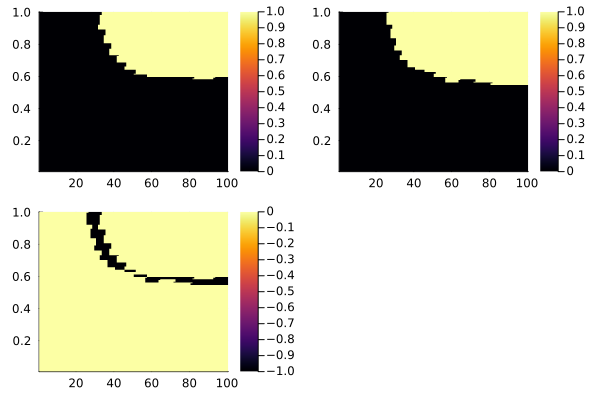

In [583]:
CV_vals = collect(0.01:0.005:1.0)
Bhat_vals = 1:1.0:100
monitoring = zeros(length(Bhat_vals),length(CV_vals))
    
acc = zeros(length(CV_vals)*length(Bhat_vals),3)
acc_base = zeros(length(CV_vals)*length(Bhat_vals),3)
k = 0
for i in 1:length(Bhat_vals)
    for j in 1:length(CV_vals)
        Var = log(CV_vals[j]^2+1)
        mu = log(Bhat_vals[i]) - 0.5*Var 
        k+=1
        acc[k,:] = [Bhat_vals[i],CV_vals[j],model.Policy([mu, Var]) .- 1]
        acc_base[k,:] = [Bhat_vals[i],CV_vals[j],model_base.Policy([mu, Var]) .- 1]
    end 
end 
p1=Plots.heatmap(Bhat_vals,CV_vals,reshape(acc[:,3],length(CV_vals),length(Bhat_vals)))
p2=Plots.heatmap(Bhat_vals,CV_vals,reshape(acc_base[:,3],length(CV_vals),length(Bhat_vals)))
p3=Plots.heatmap(Bhat_vals,CV_vals,reshape(acc[:,3].-acc_base[:,3],length(CV_vals),length(Bhat_vals)))
plot(p1,p2,p3)

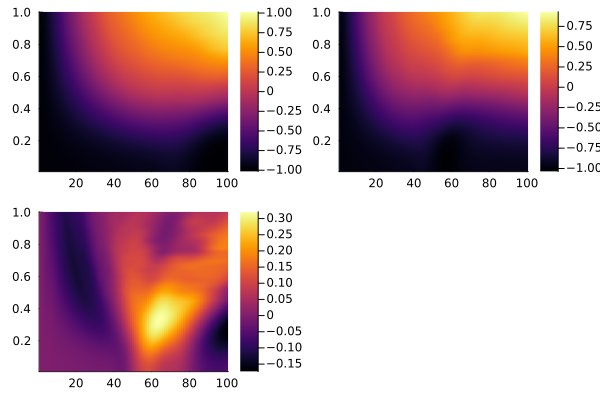

In [576]:
CV_vals = collect(0.01:0.005:1.0)
Bhat_vals = 1:1.0:100
monitoring = zeros(length(Bhat_vals),length(CV_vals))
    
acc = zeros(length(CV_vals)*length(Bhat_vals),3)
acc_base = zeros(length(CV_vals)*length(Bhat_vals),3)
k = 0
for i in 1:length(Bhat_vals)
    for j in 1:length(CV_vals)
        Var = log(CV_vals[j]^2+1)
        mu = log(Bhat_vals[i]) - 0.5*Var 
        k+=1
        acc[k,:] = [Bhat_vals[i],CV_vals[j],model.VoI([mu, Var]) .- 1]
        acc_base[k,:] = [Bhat_vals[i],CV_vals[j],model_base.VoI([mu, Var]) .- 1]
    end 
end 
p1=Plots.heatmap(Bhat_vals,CV_vals,reshape(acc[:,3],length(CV_vals),length(Bhat_vals)))
p2=Plots.heatmap(Bhat_vals,CV_vals,reshape(acc_base[:,3],length(CV_vals),length(Bhat_vals)))
p3=Plots.heatmap(Bhat_vals,CV_vals,reshape(acc[:,3].-acc_base[:,3],length(CV_vals),length(Bhat_vals)))
plot(p1,p2,p3)

In [300]:
N = 50
values_1 = zeros(N,N);values_0 = zeros(N,N)
values_1_base = zeros(N,N);values_0_base = zeros(N,N)

for i in 1:N
    for j in 1:N
        values_1[i,j]=MDPsolver.bellman!(zeros(2),2,i,j,model.grid,model.Value,model.rewards,0.9524).+ 2.0
        values_0[i,j]=MDPsolver.bellman!(zeros(2),1,i,j,model.grid,model.Value,model.rewards,0.9524).+1
        values_1_base[i,j]=MDPsolver.bellman!(zeros(2),2,i,j,model_base.grid,model_base.Value,model_base.rewards,0.9524).+ 2.0
        values_0_base[i,j]=MDPsolver.bellman!(zeros(2),1,i,j,model_base.grid,model_base.Value,model_base.rewards,0.9524).+1

    end 
end 

Bmax = 4*MSY/Fmsy
Bmin = 0.01*MSY/Fmsy
CVmax = 0.75
VoI = ValueFunctions.init_Norm2DGrid(log(Bmax),log(Bmin),log(CVmax^2+1),N)
VoI.values = reshape(values_1.-values_0, N^2)
ValueFunctions.update1!(VoI)

VoI_base = ValueFunctions.init_Norm2DGrid(log(Bmax),log(Bmin),log(CVmax^2+1),N)
VoI_base.values = reshape(values_1_base.-values_0_base, N^2)
ValueFunctions.update1!(VoI_base)
print(" ")

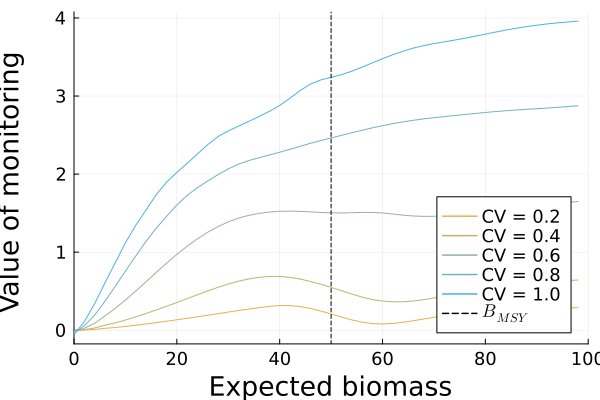

In [301]:
p2 = Plots.plot(exp.(mu_sd1),broadcast(i->VoI([mu_sd1[i],sigma[1]]),
1:length(mu_sd1)), label = "CV = 0.2",c = Colors.RGB(0.9,0.7,0.3))
Plots.plot!(exp.(mu_sd1),broadcast(i->VoI([mu_sd1[i],sigma[2]]),
1:length(mu_sd1)),label = "CV = 0.4",c = Colors.RGB(0.75,0.7,0.45))
Plots.plot!(exp.(mu_sd1),broadcast(i->VoI([mu_sd1[i],sigma[3]]),
1:length(mu_sd1)),label = "CV = 0.6",c = Colors.RGB(0.6,0.7,0.6))
Plots.plot!(exp.(mu_sd1),broadcast(i->VoI([mu_sd1[i],sigma[4]]),
1:length(mu_sd1)),label = "CV = 0.8",c = Colors.RGB(0.45,0.7,0.75))
Plots.plot!(exp.(mu_sd1),broadcast(i->VoI([mu_sd1[i],sigma[5]]), 
1:length(mu_sd1)),label = "CV = 1.0", c = Colors.RGB(0.3,0.7,0.9), xlab = "Expected biomass",
ylab = string("Value of monitoring \n"),
xguidefontsize=18,yguidefontsize=18,xtickfontsize=12,ytickfontsize=12,legendfontsize=12,
legend = :bottomright,xlims = (0,100))
Plots.vline!([50], label = L"B_{MSY}", linestyle = :dash, color = "black")
p2

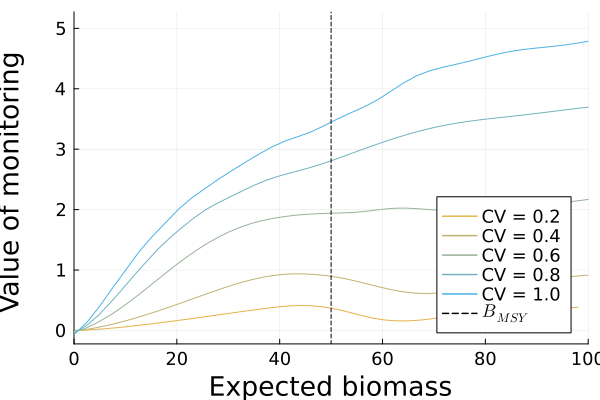

In [302]:
p2 = Plots.plot(exp.(mu_sd1.+0.5*sigma[1]),broadcast(i->VoI_base([mu_sd1[i],sigma[1]]),
1:length(mu_sd1)), label = "CV = 0.2",c = Colors.RGB(0.9,0.7,0.3))
Plots.plot!(exp.(mu_sd1.+0.5*sigma[2]),broadcast(i->VoI_base([mu_sd1[i],sigma[2]]),
1:length(mu_sd1)),label = "CV = 0.4",c = Colors.RGB(0.75,0.7,0.45))
Plots.plot!(exp.(mu_sd1.+0.5*sigma[3]),broadcast(i->VoI_base([mu_sd1[i],sigma[3]]),
1:length(mu_sd1)),label = "CV = 0.6",c = Colors.RGB(0.6,0.7,0.6))
Plots.plot!(exp.(mu_sd1.+0.5*sigma[4]),broadcast(i->VoI_base([mu_sd1[i],sigma[4]]),
1:length(mu_sd1)),label = "CV = 0.8",c = Colors.RGB(0.45,0.7,0.75))
Plots.plot!(exp.(mu_sd1.+0.5*sigma[5]),broadcast(i->VoI_base([mu_sd1[i],sigma[5]]), 
1:length(mu_sd1)),label = "CV = 1.0", c = Colors.RGB(0.3,0.7,0.9), xlab = "Expected biomass",
ylab = string("Value of monitoring \n"),
xguidefontsize=18,yguidefontsize=18,xtickfontsize=12,ytickfontsize=12,legendfontsize=12,
legend = :bottomright,xlims = (0,100))
Plots.vline!([50], label = L"B_{MSY}", linestyle = :dash, color = "black")
p2

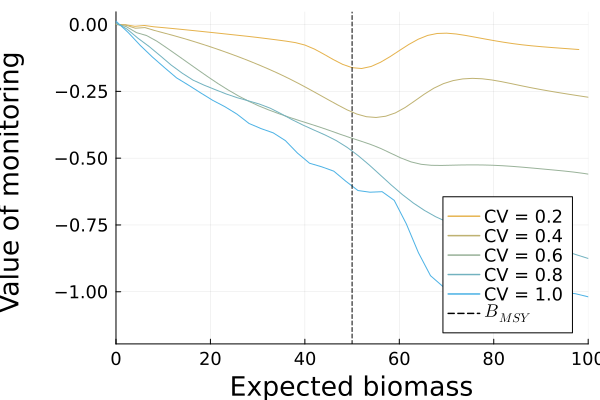

In [303]:



p2 = Plots.plot(exp.(mu_sd1.+0.5*sigma[1]),broadcast(i->VoI([mu_sd1[i],sigma[1]]).-VoI_base([mu_sd1[i],sigma[1]]),
1:length(mu_sd1)), label = "CV = 0.2",c = Colors.RGB(0.9,0.7,0.3))
Plots.plot!(exp.(mu_sd1.+0.5*sigma[2]),broadcast(i->VoI([mu_sd1[i],sigma[2]]).-VoI_base([mu_sd1[i],sigma[2]]),
1:length(mu_sd1)),label = "CV = 0.4",c = Colors.RGB(0.75,0.7,0.45))
Plots.plot!(exp.(mu_sd1.+0.5*sigma[3]),broadcast(i->VoI([mu_sd1[i],sigma[3]]).-VoI_base([mu_sd1[i],sigma[3]]),
1:length(mu_sd1)),label = "CV = 0.6",c = Colors.RGB(0.6,0.7,0.6))
Plots.plot!(exp.(mu_sd1.+0.5*sigma[4]),broadcast(i->VoI([mu_sd1[i],sigma[4]]).-VoI_base([mu_sd1[i],sigma[4]]),
1:length(mu_sd1)),label = "CV = 0.8",c = Colors.RGB(0.45,0.7,0.75))
Plots.plot!(exp.(mu_sd1.+0.5*sigma[5]),broadcast(i->VoI([mu_sd1[i],sigma[5]]).-VoI_base([mu_sd1[i],sigma[5]]), 
1:length(mu_sd1)),label = "CV = 1.0", c = Colors.RGB(0.3,0.7,0.9), xlab = "Expected biomass",
ylab = string("Value of monitoring \n"),
xguidefontsize=18,yguidefontsize=18,xtickfontsize=12,ytickfontsize=12,legendfontsize=12,
legend = :bottomright,xlims = (0,100))
Plots.vline!([50], label = L"B_{MSY}", linestyle = :dash, color = "black")
p2

In [199]:
min(1,2,3,0.1)

0.1

In [551]:
using LinearAlgebra
Matrix(I,2,2)

2×2 Matrix{Bool}:
 1  0
 0  1

In [554]:
H = [1 0 0 1]
state = [1,2,3,4]

4-element Vector{Int64}:
 1
 2
 3
 4

In [555]:
H * state

1-element Vector{Int64}:
 5

In [565]:
S = [2 0.5; 0.5 1]
D = Matrix(I,2,2).*sqrt.(diag(S))

2×2 Matrix{Float64}:
 1.41421  0.0
 0.0      1.0

In [569]:
inv(D) * S * inv(D)

2×2 Matrix{Float64}:
 1.0       0.353553
 0.353553  1.0

In [568]:
inv(D)

2×2 Matrix{Float64}:
 0.707107  0.0
 0.0       1.0

In [570]:
det(S)

1.75

In [37]:
growth(biomass,r,b) = r*biomass/(1+b*biomass)
function update(B, H,r,b)
    if B <= 0
        return 0
    end
    B = B -H
    growth(B,r,b)
end 

update (generic function with 1 method)

In [38]:
growth_rate(_BMSY,_FMSY) = (_FMSY+1)^2
density_dependence(_BMSY,_FMSY) = _FMSY/_BMSY
r1 = growth_rate(50,0.2)
r2 = growth_rate(100,0.1)
b1 = density_dependence(50,0.2)
b2 = density_dependence(100,0.1)

0.001

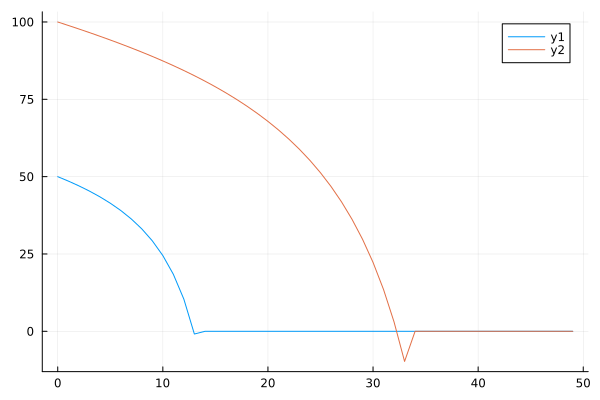

In [62]:
B1 = 50
B2 = 100
H1 = 11
H2 = 11
T = 50
v1 = zeros(T)
v2 = zeros(T)
for i in 1:T
    v1[i] = B1;v2[i] = B2
    B1 = update(B1,H1,r1,b1)
    B2 = update(B2,H2,r2,b2)
end 
using Plots
Plots.plot(collect(0:49),v1)
Plots.plot!(collect(0:49) , v2)